### Load data and Make PCA, SVM and XGboost model

In [2]:
import pandas as pd
import numpy as np
import os

In [8]:
!gzip -d final_combined.csv.gz


In [9]:
# load only column names for the data.
all_features = pd.read_csv("./final_combined.csv")

# Write out function for getting different subset of features.  
### Total three groups, all_similarity_features, all_count_features, len_entropy_features

In [10]:
def getAllNumericalCols(all_features):
    """
    param: all_features is a data frame containning all features.
    output: column names of all numerical features.
    """
    col_names = all_features.columns.tolist()
    all_num_ind = [15]+list(range(25,len(col_names)))
    all_num_col = [col_names[i] for i in all_num_ind]
    
    return all_num_col

In [11]:
all_num_features = all_features[getAllNumericalCols(all_features)]
all_num_features.head(3)

,min_levenstein_dist_brand,clean_length,title_length,desc_length,clean_terms_in_title,clean_terms_in_desc,stemmed_terms_in_title,stemmed_terms_in_desc,lemmatized_terms_in_title,lemmatized_terms_in_desc,...,jscore_query_desc,jscore_query_title,search_title_SW,search_desc_SW,NCD_query_title,num_words_in_description,num_stop_words,num_search_words,tfidf_search_common,num_attrib
0,1000,2.0,4.0,129.0,1.0,0.0,1.0,1.0,1.0,1.0,...,2.833333,0.866667,1.0,4.0,0.107077,79,0,2,1,15.0
1,1000,1.0,4.0,129.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.107077,79,0,2,0,15.0
2,0,1.0,11.0,168.0,0.0,0.0,0.0,1.0,0.0,1.0,...,2.711111,0.000000,0.0,3.0,0.109091,109,1,2,1,35.0


In [12]:
def getSimilarityCols(all_num_features):
    """
    param: all_features is a data frame containning all numerical features.
    output: column names of all similarity features.
    """
    all_similarity_features = [all_num_features.columns.tolist()[i] for i in [0,14,15,16,17,18,19,20,21,22,26]]
    return all_similarity_features

In [13]:
all_similarity_features = all_features[getSimilarityCols(all_num_features)]
all_similarity_features.head(3)

,min_levenstein_dist_brand,jaccard_index_title,jaccard_index_desc,lcs_title,lcs_desc,jscore_query_desc,jscore_query_title,search_title_SW,search_desc_SW,NCD_query_title,tfidf_search_common
0,1000,0.166667,0.000000,6,13,2.833333,0.866667,1.0,4.0,0.107077,1
1,1000,0.000000,0.000000,3,7,0.000000,0.000000,0.0,0.0,0.107077,0
2,0,0.000000,0.012048,4,4,2.711111,0.000000,0.0,3.0,0.109091,1


In [14]:
def getCountAndOtherCols(all_similarity_features,all_num_features):
    """
    return the column names of all count features and len_Entropy columns.
    """
    all_other_num_cols = set(all_num_features.columns.tolist()).difference(set(all_similarity_features.columns.tolist()))
    col_has_in = [i for i in all_other_num_cols if "in" in i]
    len_H_features = list(set(all_other_num_cols).difference(set(col_has_in)))
    
    return col_has_in, len_H_features
  

In [15]:
count_cols, len_h_cols = getCountAndOtherCols(all_similarity_features,all_num_features)
all_count_features = all_features[count_cols]
len_entropy_features = all_features[len_h_cols]

In [46]:
all_similarity_features.columns

Index(['min_levenstein_dist_brand', 'jaccard_index_title',
       'jaccard_index_desc', 'lcs_title', 'lcs_desc', 'jscore_query_desc',
       'jscore_query_title', 'search_title_SW', 'search_desc_SW',
       'NCD_query_title', 'tfidf_search_common'],
      dtype='object')

## Get the AWS working on my NCD for query and desc.

In [16]:
"search_term" in all_features.columns.tolist()
"product_description" in all_features.columns.tolist() 
raw_df = pd.DataFrame(all_features[["search_term","product_description"]])

### Plan on the modelling plan.

Start from simple features and estimated on each model, like SVM.LinearSVR or LinearRegression.  
Include only numerical attributes, exclude 0-4.  

In [17]:
from sklearn.svm import LinearSVR
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler

In [18]:
label = all_features["relevance"]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(all_num_features, label)

In [20]:
X_train = np.nan_to_num(X_train)

In [25]:
def standaridize(df):
    """
    Given a vector or a matrix, use the standardize to modify the data. Useful in SVM, L1/L2 regulared linear regression.
    return: standaridized data set.
    """
    if len(np.array(df).shape) == 1:
        df = np.array(df).reshape(-1,1)
    scaler = StandardScaler()
    std_df = scaler.fit_transform(df)
    return std_df

In [26]:
def runLinearModels(df,label):
    """
    param: pandas data frame with numerical columns.
    return: the best model.
    """
    df = standaridize(df)
    
    X_train, X_test, y_train, y_test = train_test_split(df, label)
    # Add a quick fix for nan, inf. 
    X_train = np.nan_to_num(X_train)
    X_test = np.nan_to_num(X_test)
    
    #For linear regression.
    lr = linear_model.LinearRegression()
    lr_params = {"fit_intercept":[True,False],'normalize':[True,False],"n_jobs":[-1]}
    lr_gs = GridSearchCV(lr,n_jobs=-1,cv=5,param_grid=lr_params)
    lr_gs.fit(X_train,y_train)
    lr_predicted = lr_gs.predict(X_test)
    lr_rmse = math.sqrt(mean_squared_error(lr_predicted, y_test))

    #For Lasso, the key parameter to tune on is alpha, and it is numerical within range of 0 and 1.
    lsso = linear_model.Lasso(random_state=42,tol=0.001)
    lsso_params = {"fit_intercept":[True,False],'normalize':[True,False],"alpha":list(np.linspace(0.25,1.5,num=20))}
    lsso_gs = GridSearchCV(lsso,n_jobs=-1,cv=5,param_grid=lsso_params)
    lsso_gs.fit(X_train,y_train)
    lsso_predicted = lsso_gs.predict(X_test)
    lsso_rmse = math.sqrt(mean_squared_error(lsso_predicted, y_test))

    #For Ridge, the key parameter is alpha.
    ridge = linear_model.Ridge(random_state=42,tol=0.001)
    ridge_params = {"fit_intercept":[True,False],'normalize':[True,False],"alpha":list(np.linspace(0.25,4,num=40))}
    ridge_gs = GridSearchCV(ridge,n_jobs=-1,cv=5,param_grid=ridge_params)
    ridge_gs.fit(X_train,y_train)
    ridge_predicted = ridge_gs.predict(X_test)
    ridge_rmse = math.sqrt(mean_squared_error(ridge_predicted, y_test))

    #For Elastic nets, the key parameter is alpha and l1_ratio, both of them are numerical.
    elNet = linear_model.ElasticNet(random_state=42,tol=0.001)
    elNet_params = {"fit_intercept":[True,False],'normalize':[True,False],"alpha":list(np.linspace(0.25,1,num=20)),"l1_ratio":list(np.linspace(0,1,num=10))}
    elNet_gs = GridSearchCV(elNet,n_jobs=-1,cv=5,param_grid=elNet_params)
    elNet_gs.fit(X_train,y_train)
    elNet_predicted = elNet_gs.predict(X_test)
    elNet_rmse = math.sqrt(mean_squared_error(elNet_predicted, y_test))
    
    all_rmse = [lr_rmse, lsso_rmse, ridge_rmse, elNet_rmse] 
    model_names = [lr_gs, lsso_gs, ridge_gs, elNet_gs]
    best_model = dict(zip(model_names, all_rmse))

    return best_model

In [27]:
# Use smallest data set to train. Best performance is LinearRegression.
# This runs 2m 38s. 
linear_family = runLinearModels(len_entropy_features,label)

/Users/jw/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jw/miniconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/jw/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [28]:
# get all linear family regression.

linear_family2 = runLinearModels(all_count_features,label)

/Users/jw/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jw/miniconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/jw/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [29]:
linear_family3 = runLinearModels(all_similarity_features,label)

/Users/jw/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jw/miniconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/jw/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [30]:
linear_family4 = runLinearModels(all_num_features,label)

/Users/jw/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jw/miniconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/jw/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


### Analyze the result of all linear family models on four 

In [48]:
linear_family4

{GridSearchCV(cv=5, error_score='raise-deprecating',
        estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
        fit_params=None, iid='warn', n_jobs=-1,
        param_grid={'fit_intercept': [True, False], 'normalize': [True, False], 'n_jobs': [-1]},
        pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
        scoring=None, verbose=0): 0.4926933396651761,
 GridSearchCV(cv=5, error_score='raise-deprecating',
        estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
    normalize=False, positive=False, precompute=False, random_state=42,
    selection='cyclic', tol=0.001, warm_start=False),
        fit_params=None, iid='warn', n_jobs=-1,
        param_grid={'fit_intercept': [True, False], 'normalize': [True, False], 'alpha': [0.25, 0.3157894736842105, 0.381578947368421, 0.4473684210526316, 0.513157894736842, 0.5789473684210527, 0.6447368421052632, 0.7105263157894737, 0.7763157894736842, 0.8

## Another metrics for all linear family model.

In [569]:
def getDFSplit(df):
    df = standaridize(df)

    X_train, X_test, y_train, y_test = train_test_split(df, label)
    # Add a quick fix for nan, inf. 
    X_train = np.nan_to_num(X_train)
    X_test = np.nan_to_num(X_test)
    
    return X_train, X_test, y_train, y_test

In [570]:
X_train, X_test, y_train, y_test = getDFSplit(all_num_features)

/Users/jw/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jw/miniconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [577]:
r2_ls = []
for i in list(linear_family4.keys()):
    r2 = i.best_estimator_.score(X_test,y_test)
    name = str(i.best_estimator_).split("(")[0]
    
    r2_ls.append((name,r2))

In [591]:
[(i[0],"{:.4f}".format(i[1])) for i in r2_ls]

[('LinearRegression', '0.1481'),
 ('Lasso', '-0.0000'),
 ('Ridge', '0.1481'),
 ('ElasticNet', '0.1405')]

### Plot the R2 for all linear model

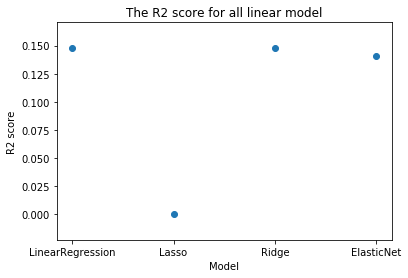

In [588]:
plt.scatter([i[0] for i in r2_ls],[i[1] for i in r2_ls])
plt.title("The R2 score for all linear model")
plt.xlabel("Model")
plt.ylabel("R2 score")
plt.show()

## Try on svm, but it took too long...

In [171]:
def runSVMregession(df,label):
    """
    Doing SVM regression on large data set require specify the cache size, scale input X data to [0,1]/[-1,1]
        avoid 
    param: pandas data frame with numerical columns.
    return: the best model.
    """
    # Scale the df.
    df = standaridize(df)
    X_train, X_test, y_train, y_test = train_test_split(df, label)
    # Add a quick fix for nan, inf. 
    X_train = np.nan_to_num(X_train)
    X_test = np.nan_to_num(X_test)
    
    svm = LinearSVR(random_state=42,max_iter=5000,C=100,epsilon=0.075)
    #svm_regression_params = {"tol":[10**(-4)],'C':[1,10,20],"epsilon":[0.1,0.2,0.075],"max_iter":[4000,2000]}
    svm_gs = GridSearchCV(svm,n_jobs=-1,cv=3,param_grid=svm_regression_params)
    svm_gs.fit(X_train,y_train)
    svm_predicted = svm_gs.predict(X_test)
    svm_rmse = math.sqrt(mean_squared_error(svm_predicted,y_test))
    
    return [svm_gs,svm_rmse]

In [172]:
svm_ls = runSVMregession(len_entropy_features,label)
svm_ls

/Users/jw/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jw/miniconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/jw/miniconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[GridSearchCV(cv=3, error_score='raise-deprecating',
        estimator=LinearSVR(C=100, dual=True, epsilon=0.075, fit_intercept=True,
      intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=5000,
      random_state=42, tol=0.0001, verbose=0),
        fit_params=None, iid='warn', n_jobs=-1,
        param_grid={'tol': [0.0001, 1e-05], 'C': [1, 10, 20, 100, 300], 'epsilon': [0.1, 0.2, 0.075], 'max_iter': [4000, 5000, 10000]},
        pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
        scoring=None, verbose=0), 0.5347747376877314]

In [1]:
svm_ls1

NameError: name 'svm_ls1' is not defined

In [ ]:
svm_ls2 = runSVMregession(all_count_features,label)

In [ ]:
svm_ls2

In [ ]:
svm_ls3 = runSVMregession(all_similarity_features,label)

In [ ]:
svm_ls3

In [ ]:
svm_ls4 = runSVMregession(all_num_features,label)

In [ ]:
svm_ls4

In [ ]:
# collect all svm performance.
rmse_svm = [i[1] for i in [svm_ls,svm_ls2,svm_ls3,svm_ls4]]

In [152]:
rmse_svm

[0.5562035877884243,
 0.5254573621899448,
 0.5076691880561738,
 0.5418303047801409]

In [12]:
def runXGBoost(df):
    """
    ref: https://xgboost.readthedocs.io/en/latest/python/python_intro.html
    param: pandas data frame with numerical columns.
    return: the best model.
    """
    
    # specify parameters via map, definition are same as c++ version
    param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'binary:logistic'}

    # specify validations set to watch performance
    watchlist = [(dtest, 'eval'), (dtrain, 'train')]
    num_round = 2
    bst = xgb.train(param, dtrain, num_round, watchlist)

    # this is prediction
    preds = bst.predict(dtest)
    labels = dtest.get_label()
    
    

## Doing PCA on for linear regression on four spaces.

In [332]:
df = standaridize(all_num_features)
X_train, X_test, y_train, y_test = train_test_split(df, label)
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)
# Add a quick fix for nan, inf. 


/Users/jw/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jw/miniconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [351]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

0.4953426535601246

In [607]:
def pcaOnLR(df):
    """
    This function is to apply PCA on potentially correlated feature space to reduce multicollinearity and remove 
        redundent features. Comparing the lr modelling on all numerical features, it will show the superiority/or not.
    param: df is the data source we want to run pca and lr.
    return the model object with the rmse score.
    """
    features_len = len(df.columns)
    df = standaridize(df)
    X_train, X_test, y_train, y_test = train_test_split(df, label)
    X_train = np.nan_to_num(X_train)
    X_test = np.nan_to_num(X_test)
    
    pipe_lr = Pipeline([         # Transformer: Standardize
                    ('pca', PCA()),                   # Transformer: Dimension Reduction
                    ('lr', linear_model.LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=True))]) # Estimator: ML algorithm
    param_ls = [
        {
            'pca__n_components': range(2,features_len,1)
        }
    ]
    pca_lr_gs = GridSearchCV(estimator=pipe_lr,param_grid=param_ls,cv=5)
    pca_lr_gs.fit(X_train,y_train)
    pca_pip_predicted = pca_lr_gs.predict(X_test)
    pca_pip_rmse = math.sqrt(mean_squared_error(pca_pip_predicted, y_test))
    
    return pca_pip_predicted,pca_lr_gs, pca_pip_rmse

In [608]:
pred,pca_lr_gs, pca_pip_rmse = pcaOnLR(all_num_features)

/Users/jw/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jw/miniconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [612]:
np.square(pred-y_test)/np.square(y_test-np.mean(y_test))

61653    0.261604
34662    0.148597
47392    0.009133
19101    0.544603
38232    0.090843
10902    0.028670
18373    0.176695
47835    0.669430
67884    0.121925
73780    0.441422
24646    0.003728
28130    0.325790
34571    0.052764
21555    0.078212
72679    0.154154
59510    0.341351
21877    0.045105
60510    0.203375
30682    0.039623
20593    0.204074
18220    0.039109
45718    0.226164
60630    0.044756
22942    0.243467
47323    0.118442
47225    0.251371
49221    0.322320
42902    0.004998
46826    0.849998
46206    0.415369
           ...   
70204    0.728130
27112    0.380386
65795    0.036314
16509    0.000912
20301    0.440323
38202    0.049572
68108    0.972167
57570    0.056282
54344    0.370680
57847    0.815083
9792     2.006352
21952    0.135367
50148    0.038532
3267     0.221981
17548    0.000866
67353    0.189004
25124    0.175822
70918    0.244828
26477    0.134458
52906    0.431188
64150    0.145646
10297    0.193701
19937    0.016909
59873    1.622999
31283    0

In [369]:
pca_pip_rmse

0.4922686936780145

In [371]:
# The slight improvement from PCA.
list(linear_family4.values())[0]-pca_pip_rmse

0.000424645987161576

## Doing visualization.

In [66]:
import matplotlib.pyplot as plt

In [151]:
#plot line graph for each features space.

features_ls = ["length&Entropy","Counts features","Similarity scores","Numerical Features!"]
color_ls = ['green','blue','orange','red']
model_ls = ["Linear Regression","Lasso","Ridge","Elastic Net"]


In [152]:
sorted( list(linear_family.items()) ,key = lambda x:x[1])
model_1 = ["Ridge","LinearRegression","ElasticNet","Lasso"]
model_1_rmse = [ i[1] for i in sorted(list(linear_family.items()),key = lambda x:x[1])]
str(list(linear_family.keys())[0].best_estimator_)

'LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)'

In [153]:
rmse_lr = list(linear_family.values())
rmse_lasso = list(linear_family2.values())
rmse_ridge = list(linear_family3.values())
rmse_elNet = list(linear_family4.values())
rmse_ls = [rmse_lr,rmse_lasso,rmse_ridge,rmse_elNet]
linear_family_ls = [linear_family,linear_family2,linear_family3,linear_family4]


model_ls = []
for i in list(linear_family.keys()):
    # Get names for the model:
    best_estimator = str(i.best_estimator_)
    best_model = best_estimator.split("(")[0]
    model_ls.append(best_model)

In [300]:
def plotRMSEonModels(model_ls,rmse_ls,color_ls):
    for i in range(len(model_ls)):
        plt.plot(model_ls,rmse_ls[i], color=color_ls[i])
    plt.ylabel('RMSE')
    title = "Line graph of RMSE "+ " on Different Linear Models"
    plt.legend((features_ls[0], features_ls[1], features_ls[2],features_ls[3]),loc='best',bbox_to_anchor=(1.05, 1))
    plt.title(title)
    
    plt.show()

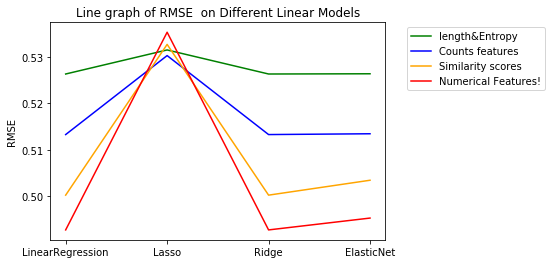

In [301]:
plotRMSEonModels(model_ls,rmse_ls,color_ls)

In [156]:
a = [list(linear_family.values()),list(linear_family2.values()),list(linear_family3.values()),list(linear_family4.values())]

In [157]:
ls = [[0.5263485164708134,0.51327591053854,0.5002002234986587,0.4926933396651761],[0.531539550022558,0.5303252482589123,0.5327391186268694,0.5353628881490203],[0.5263483337776417,0.5132759618051421,0.5001997074428409,0.49269318624853387],[0.5263991339470047,0.5134492318882742,0.5034151480607402,0.49525024975370924]]

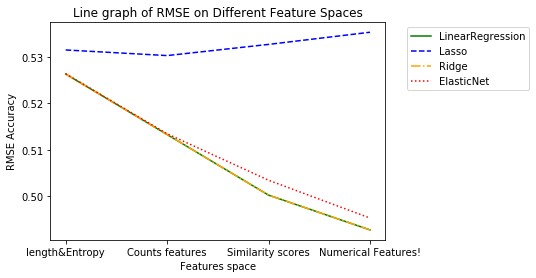

In [288]:
style_ls = ['-', '--', '-.', ':']
for i in range(len(ls)):
    plt.plot(features_ls,ls[i],color=color_ls[i],linestyle=style_ls[i])
    plt.xlabel("Features space")
    plt.ylabel('RMSE Accuracy')
    title = "Line graph of RMSE on "+"Different Feature Spaces"
    plt.title(title)
plt.legend((model_ls[0], model_ls[1], model_ls[2],model_ls[3]),loc='best',bbox_to_anchor=(1.05, 1))
plt.show()

In [181]:
df = standaridize(all_num_features)
    
X_train, X_test, y_train, y_test = train_test_split(df, label)
# Add a quick fix for nan, inf. 
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)

/Users/jw/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jw/miniconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


## Show all significant coefficients in linear regression.

In [194]:
def getCoefSignificant(linear_family,df):
    """
    This function return the corresponding coefficients in linear regression, the bigger score the more significant it is.
    param: grid search result to give the model we have and its corresponding coefficients.
    param: df the data frame it is used to train the linear family of models.
    """
    coef_all_num = list(linear_family.keys())[0].best_estimator_.coef_
    all_num_cols = df.columns.tolist()
    return sorted(zip(all_num_cols,coef_all_num),key= lambda x:x[1],reverse=True)
    

In [221]:
a = getCoefSignificant(linear_family4,all_num_features)[:5]+getCoefSignificant(linear_family4,all_num_features)[-5:]
[i[0] for i in a]
[i[1] for i in a]

[0.12539467627477924,
 0.08200592248021002,
 0.07359039834716466,
 0.049850754667436464,
 0.04087177610879655,
 -0.037551516524872416,
 -0.03771984729480559,
 -0.06108339470320307,
 -0.07134411191331363,
 -0.14396236313703653]

Text(0,0.5,'Coefficient Value')

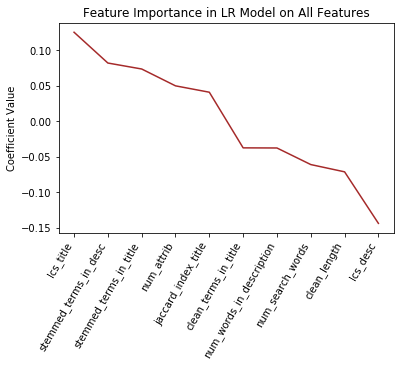

In [522]:
plt.plot([i[0] for i in a],[i[1] for i in a],color="brown")
plt.xticks(rotation=60,ha="right")
plt.title("Feature Importance in LR Model on All Features")
plt.subplots_adjust(bottom=0.15)
plt.ylabel("Coefficient Value")

In [250]:
b = getCoefSignificant(linear_family3,all_similarity_features)

Text(0,0.5,'Coefficient Value')

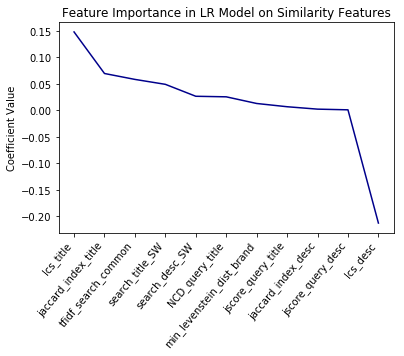

In [517]:
plt.plot([i[0] for i in b],[i[1] for i in b],color="darkblue")
plt.xticks(rotation=50,ha="right")
plt.title("Feature Importance in LR Model on Similarity Features")
plt.subplots_adjust(bottom=0.15)
plt.ylabel("Coefficient Value")

In [238]:
c = getCoefSignificant(linear_family2,all_count_features)

Text(0,0.5,'Coefficient Value')

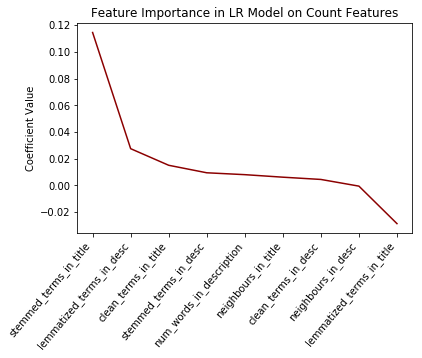

In [520]:
plt.plot([i[0] for i in c],[i[1] for i in c],color="darkred")
plt.xticks(rotation=50,ha="right")
plt.title("Feature Importance in LR Model on Count Features")
plt.subplots_adjust(bottom=0.15)
plt.ylabel("Coefficient Value")

In [259]:
d = getCoefSignificant(linear_family,len_entropy_features)

Text(0,0.5,'Coefficient Value')

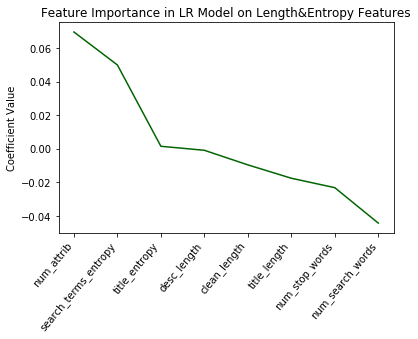

In [521]:
plt.plot([i[0] for i in d],[i[1] for i in d],color="darkgreen")
plt.xticks(rotation=50,ha="right")
plt.title("Feature Importance in LR Model on Length&Entropy Features")
plt.subplots_adjust(bottom=0.15)
plt.ylabel("Coefficient Value")

Showing all features' importance in all four linear regression models.

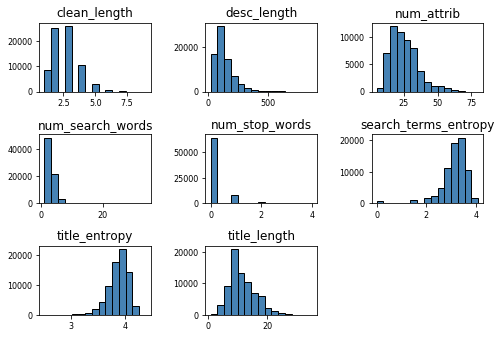

In [302]:
len_entropy_features.hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)    
plt.tight_layout(rect=(0, 0, 1.2, 1.2))   

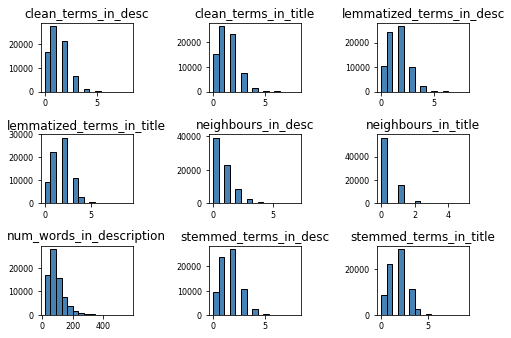

In [303]:
all_count_features.hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)    
plt.tight_layout(rect=(0, 0, 1.2, 1.2))   

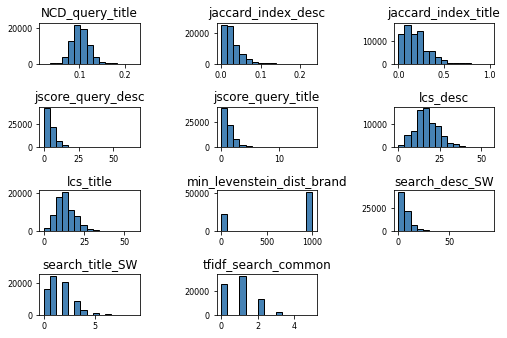

In [304]:
all_similarity_features.hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)    
plt.tight_layout(rect=(0, 0, 1.2, 1.2))   

### Get the correlation matrix

In [318]:
import seaborn as sns

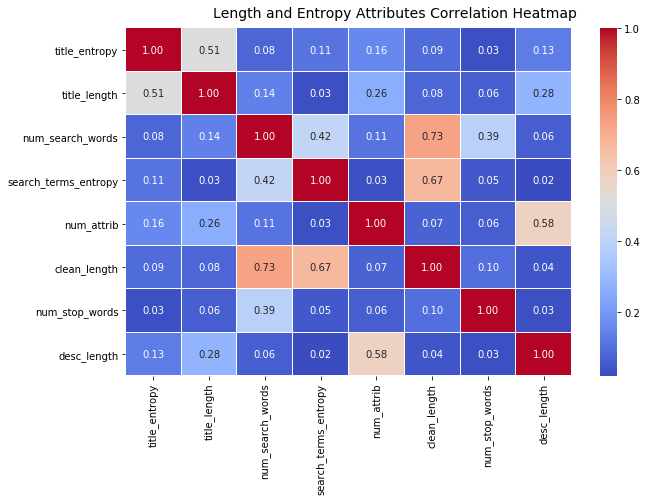

In [319]:
# Correlation Matrix Heatmap
f, ax = plt.subplots(figsize=(10, 6))
corr = len_entropy_features.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Length and Entropy Attributes Correlation Heatmap', fontsize=14)

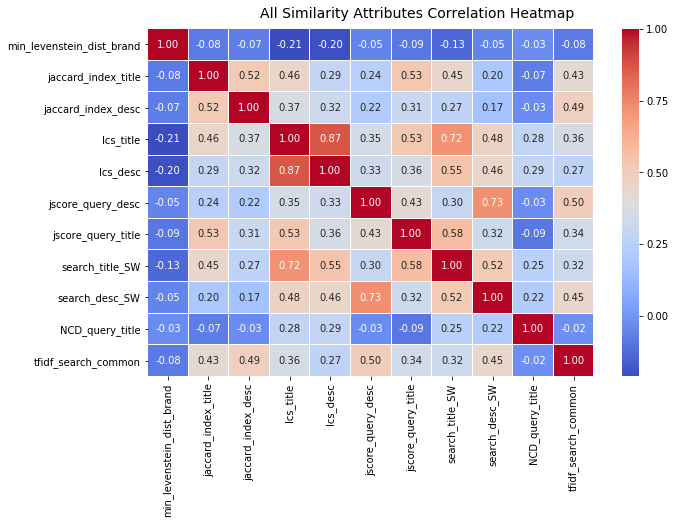

In [320]:
# Correlation Matrix Heatmap
f, ax = plt.subplots(figsize=(10, 6))
corr = all_similarity_features.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('All Similarity Attributes Correlation Heatmap', fontsize=14)

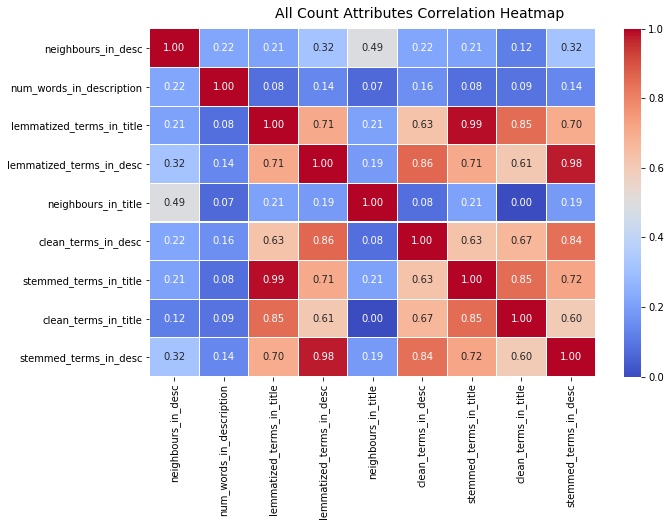

In [321]:
# Correlation Matrix Heatmap
f, ax = plt.subplots(figsize=(10, 6))
corr = all_count_features.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('All Count Attributes Correlation Heatmap', fontsize=14)

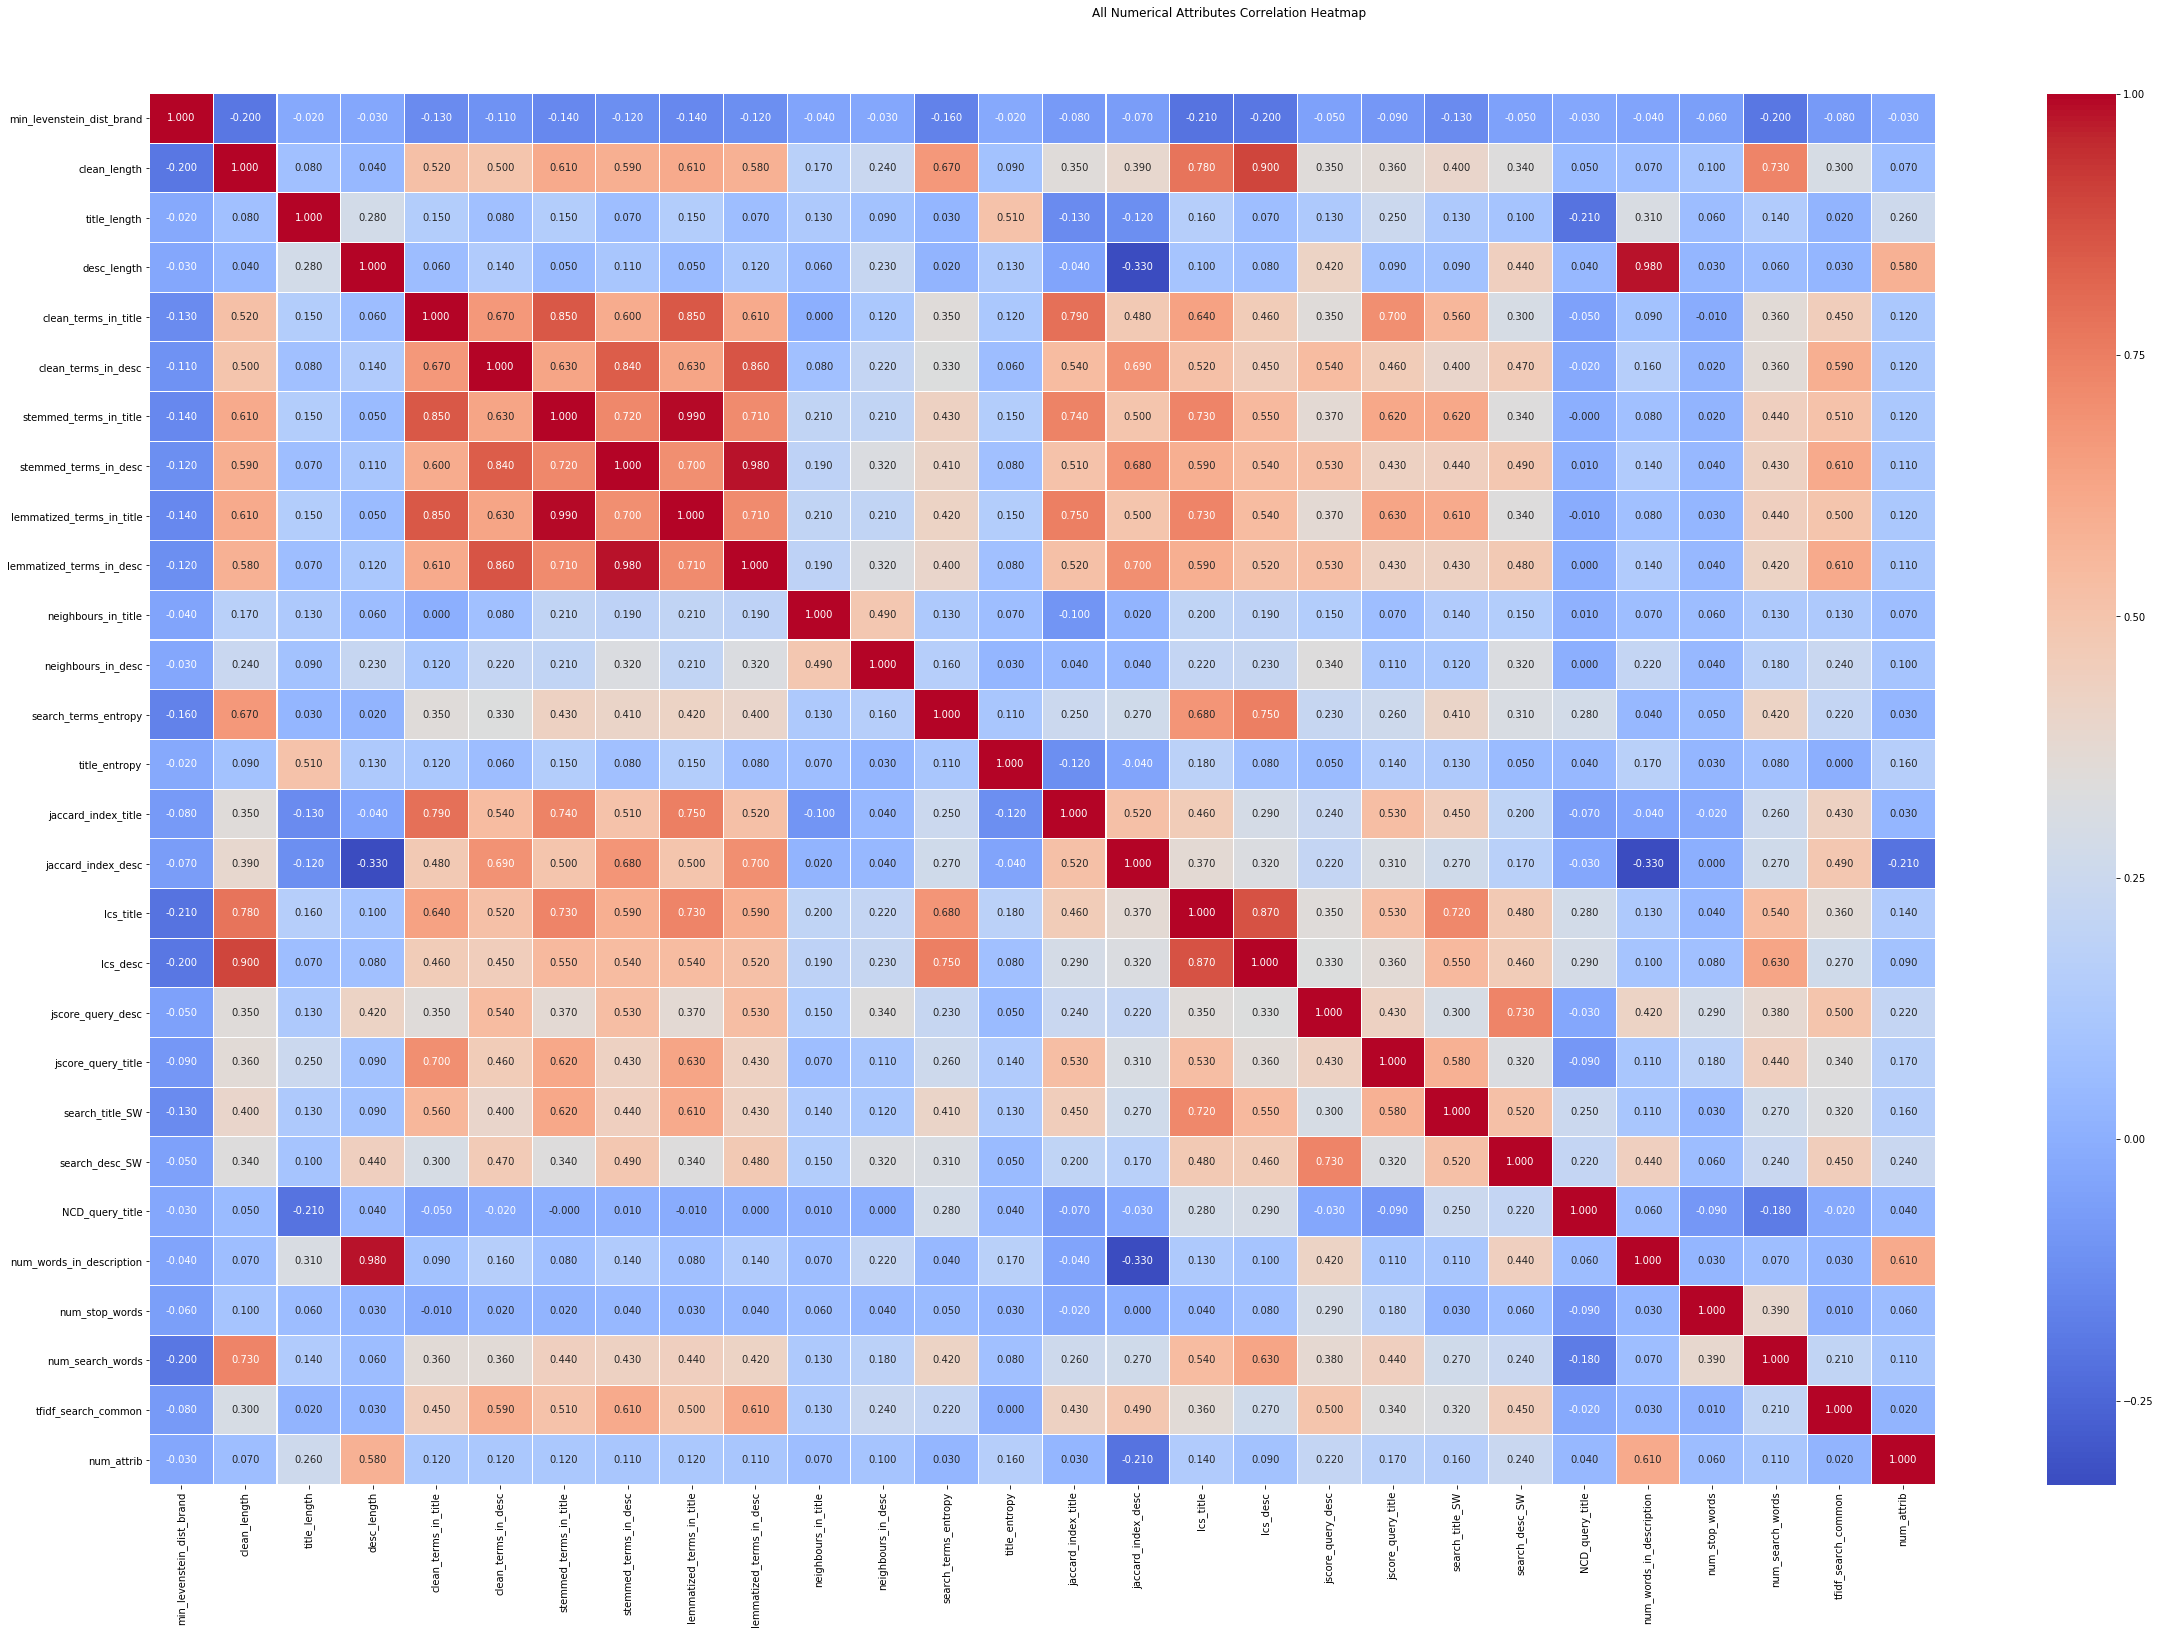

In [323]:
# Correlation Matrix Heatmap
f, ax = plt.subplots(figsize=(40, 24))
corr = all_num_features.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.3f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('All Numerical Attributes Correlation Heatmap', fontsize=12)

In [326]:
linear_family3.values()

dict_values([0.5002002234986587, 0.5327391186268694, 0.5001997074428409, 0.5034151480607402])

In [327]:
linear_family4.values()

dict_values([0.4926933396651761, 0.5353628881490203, 0.49269318624853387, 0.49525024975370924])

### Plot the Tree based model progression

In [384]:
[("rmse_tree",0.4758),
("rmse_rf",0.4688),
("rmse_PCA_rf",0.4683)]

[('rmse_tree', 0.4758), ('rmse_rf', 0.4688), ('rmse_PCA_rf', 0.4683)]

RF

[(0.47633563539292706, {'max_features': 'log2', 'n_estimators': 139}, RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]

Initial Tree

[(0.49136759545324854, {'max_features': 'sqrt', 'n_estimators': 26}, RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)), (0.5086641222487406, {'learning_rate': 0.5, 'loss': 'linear', 'n_estimators': 6}, AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=None))]
         
PCA on RF

[(0.4695884434881894, {'max_features': 'log2', 'n_estimators': 140}, RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]

/Users/jw/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jw/miniconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


#### First RF model.  
It gives 0.47163 as rmse.

In [399]:
from sklearn.ensemble import RandomForestRegressor

In [472]:
# Run RF model on all_numerical_features
def runRFModel(df,numEst,pca_indicator):
    """ 
    Run RandomForest model.
    """
    
    col_len = len(df.columns)
    df = standaridize(all_num_features)
    X_train, X_test, y_train, y_test = train_test_split(df, label)
    # Add a quick fix for nan, inf. 
    X_train = np.nan_to_num(X_train)
    X_test = np.nan_to_num(X_test)
    
    if pca_indicator == True:
        rf = Pipeline([('pca', PCA(n_components=17)),
                        ('regr', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None, 
                                                                  max_features='log2', max_leaf_nodes=None, 
                                                                  min_impurity_decrease=0.0, min_impurity_split=None,
                                                                  min_samples_leaf=1, min_samples_split=2, 
                                                                  min_weight_fraction_leaf=0.0, n_estimators=numEst, 
                                                                  n_jobs=None, oob_score=False, random_state=42, 
                                                                  verbose=0, warm_start=False))])
        rf.fit(X_train, y_train)
        pca_rf_pip_predict = rf.predict(X_test)
        rmse = math.sqrt(mean_squared_error(pca_rf_pip_predict,y_test))
        
    else:
        rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None, max_features='auto', 
                                        max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, 
                                        min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, 
                                        n_estimators=numEst, n_jobs=None, oob_score=False, random_state=42, verbose=0,
                                        warm_start=False)

        rf.fit(X_train,y_train)
        rf_pred = rf.predict(X_test)
        rmse = math.sqrt(mean_squared_error(rf_pred, y_test))
    return rf,rmse

In [473]:
rf_first,rf_rmse_1 = runRFModel(all_num_features,26,False)

/Users/jw/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jw/miniconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [474]:
rf_rmse_1

0.4748500719600165

In [475]:
def getFeatureImp(rf,df):
    """
    Given random Forest model and the data set. We can compute the feature importance.
    param rf: random forest model
    param df: the data frame
    return: a descending list of tuple with feature name and its feature importance number.
    """
    rf_feature_imp = list(zip(df.columns.tolist(),rf.feature_importances_))
    feature_imp_ls = sorted(rf_feature_imp, key=lambda x:x[1],reverse=True)
    return feature_imp_ls

In [483]:
rf_fImp = getFeatureImp(rf_first,all_num_features)

## Run Better RF

In [477]:
rf_better,rf_rmse_2 = runRFModel(all_num_features,139,False)

/Users/jw/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jw/miniconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [478]:
rf_rmse_2

0.4645370731903928

In [479]:
rf_2_fImp = getFeatureImp(rf_better,all_num_features)

[('title_entropy', 0.08545124990455981),
 ('NCD_query_title', 0.08345773384533921),
 ('stemmed_terms_in_title', 0.07790126191333846),
 ('search_terms_entropy', 0.060924891552846784),
 ('jscore_query_desc', 0.05915441193994205),
 ('num_attrib', 0.05898588079499938),
 ('desc_length', 0.05784956029543801),
 ('num_words_in_description', 0.05311577840619377),
 ('num_search_words', 0.0488289390713006),
 ('jaccard_index_desc', 0.04718456838187365),
 ('title_length', 0.0468826058483324),
 ('jscore_query_title', 0.04654756918732565),
 ('jaccard_index_title', 0.03804757062861779),
 ('lcs_title', 0.0366337605510694),
 ('search_desc_SW', 0.03622705962922253),
 ('lcs_desc', 0.0357384285631842),
 ('tfidf_search_common', 0.019228086526853434),
 ('search_title_SW', 0.01804663741717478),
 ('min_levenstein_dist_brand', 0.015113221633959395),
 ('neighbours_in_desc', 0.013662104437462031),
 ('stemmed_terms_in_desc', 0.011477421025663863),
 ('clean_length', 0.008770356710018886),
 ('lemmatized_terms_in_tit

## Run PCA+RF

In [480]:
rf_pca,rf_rmse_3 = runRFModel(all_num_features,140,True)

/Users/jw/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jw/miniconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [481]:
rf_rmse_3

0.481767947069506

In [482]:
pca_rf_fimp = getFeatureImp(rf_pca.steps[1][1],all_num_features)

[('min_levenstein_dist_brand', 0.09882901414031214),
 ('title_length', 0.08933610114177118),
 ('clean_terms_in_title', 0.07676347590346726),
 ('stemmed_terms_in_title', 0.058940697256259104),
 ('clean_terms_in_desc', 0.05756413023552799),
 ('lemmatized_terms_in_title', 0.055592620260238146),
 ('jaccard_index_desc', 0.054825770609617526),
 ('clean_length', 0.052008744110690626),
 ('desc_length', 0.05188564575428371),
 ('search_terms_entropy', 0.05159613336735153),
 ('jaccard_index_title', 0.051008758605124487),
 ('neighbours_in_title', 0.05076996592887838),
 ('title_entropy', 0.050708630686516945),
 ('lemmatized_terms_in_desc', 0.05062344406752044),
 ('stemmed_terms_in_desc', 0.05033886103948068),
 ('neighbours_in_desc', 0.05013075024706983),
 ('lcs_title', 0.04907725664589)]

Text(0,0.5,'Relative Importance')

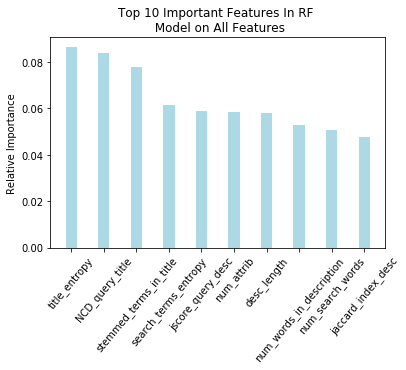

In [502]:
rf_fImp = getFeatureImp(rf_first,all_num_features)
rf_fImp = rf_fImp[:10]
plt.bar([i[0] for i in rf_fImp],[i[1] for i in rf_fImp],color="lightblue",width=0.35)
plt.xticks(rotation=50)
plt.title("Top 10 Important Features In RF \n Model on All Features")
plt.subplots_adjust(bottom=0.15)
plt.ylabel("Relative Importance")
# Figure out how to compute the feature importance.

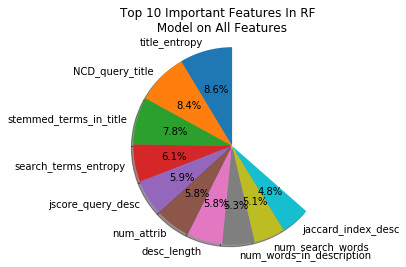

0.6351694271471934


In [509]:
fig1, ax1 = plt.subplots()
ax1.pie(labels=[i[0] for i in rf_fImp],x=[i[1] for i in rf_fImp], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Top 10 Important Features In RF \n Model on All Features")
plt.show()

print(sum([i[1] for i in rf_fImp]))

### On pca and random forest.

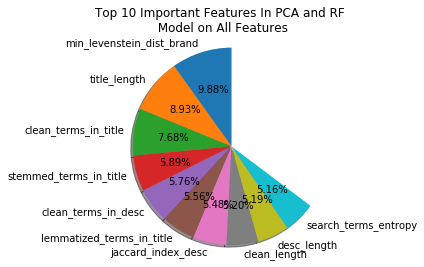

0.6473423327795191


In [510]:
pca_rf_fimp = getFeatureImp(rf_pca.steps[1][1],all_num_features)[:10]

fig1, ax1 = plt.subplots()
ax1.pie(labels=[i[0] for i in pca_rf_fimp],x=[i[1] for i in pca_rf_fimp], autopct='%1.2f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Top 10 Important Features In PCA and RF \n Model on All Features")
plt.show()

print(sum([i[1] for i in pca_rf_fimp]))

Get the random chance benchmark.

In [516]:
len(label) # no empty relevancy score.

74071

In [526]:
random_score = np.random.uniform(low=1.0,high=3.0,size=len(label))

In [527]:
random_chance_performance = math.sqrt(mean_squared_error(random_score, label))

In [528]:
random_chance_performance

0.8774250971128439

Make a plot about our model's performance on test set for different random states.

In [535]:
df = standaridize(all_num_features)

def getDistributionOfModel(df,label,iterNum):
    """
    To run some iteration of model fitting and to get the distribution of model performances.
    
    Notice: Before we run, we need get our dataset standardize.
    
    param: df: the data set to train and split.
    param: iterNum: the number of data points for the model.
    param: label: the actual value of target.
    return: a list to hold the random statue code and the rmse score.
    """
    result_ls = []
    random_state_ls = np.random.permutation(np.arange(50))[:iterNum]
    
    for i in random_state_ls:
    
        X_train, X_test, y_train, y_test = train_test_split(df, label)
        # Add a quick fix for nan, inf. 
        X_train = np.nan_to_num(X_train)
        X_test = np.nan_to_num(X_test)

        rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None, max_features='auto', 
                                        max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, 
                                        min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, 
                                        n_estimators=139, n_jobs=None, oob_score=False, random_state=i, verbose=0,
                                        warm_start=False)

        rf.fit(X_train,y_train)
        rf_pred = rf.predict(X_test)
        rmse = math.sqrt(mean_squared_error(rf_pred, y_test))
        result_ls.append(tuple([i,rmse]))
    return result_ls
    

/Users/jw/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jw/miniconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [536]:
performance_ls = getDistributionOfModel(df,label,3)

In [537]:
performance_ls2 = getDistributionOfModel(df,label,27)

In [538]:
all_performance_ls = performance_ls+performance_ls2

In [546]:
import scipy.stats as stats
import seaborn as sns

In [542]:
dist_to_plot = sorted( all_performance_ls ,key=lambda x:x[1] )
rmse_val = [i[1] for i in dist_to_plot]

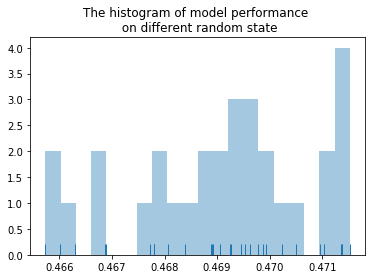

In [560]:
sns.distplot(rmse_val, bins=20, kde=False, rug=True);
plt.title("The histogram of model performance \n on different random state")
plt.show()